<a href="https://colab.research.google.com/github/Anirudh-on-GitHub/DL-Codes/blob/master/TLKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


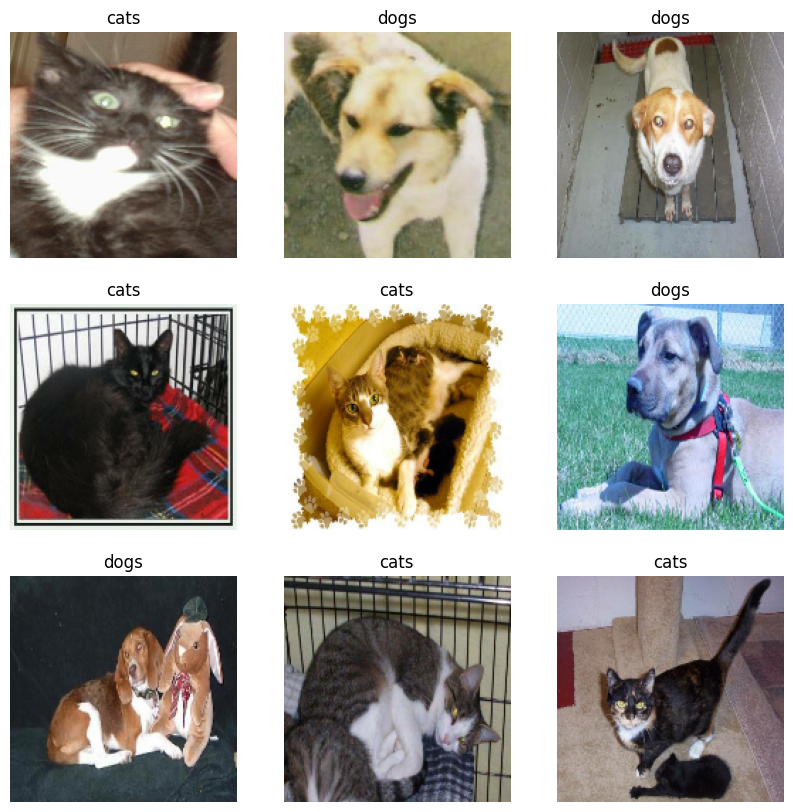

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

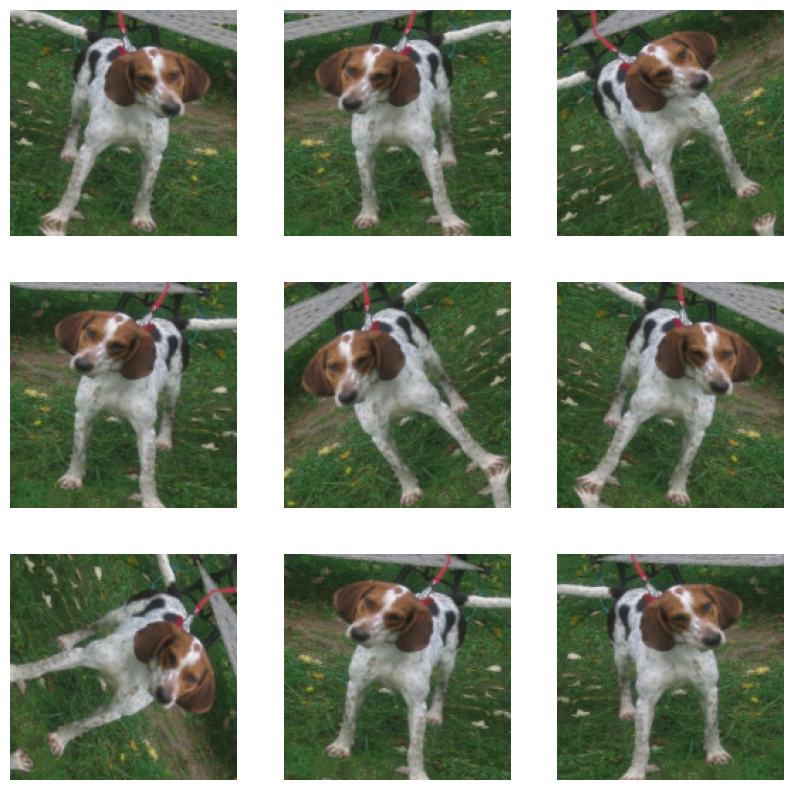

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 53ms/step - loss: 0.7909 - accuracy: 0.5582


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.56


In [ ]:
history = model.fit(
    train_dataset, epochs=initial_epochs, validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 9s 66ms/step - loss: 0.6472 - accuracy: 0.6690 - val_loss: 0.4939 - val_accuracy: 0.7116
Epoch 2/10
63/63 [==============================] - 5s 78ms/step - loss: 0.4906 - accuracy: 0.7430 - val_loss: 0.3660 - val_accuracy: 0.8168
Epoch 3/10
63/63 [==============================] - 4s 52ms/step - loss: 0.4029 - accuracy: 0.8060 - val_loss: 0.2907 - val_accuracy: 0.8589
Epoch 4/10
63/63 [==============================] - 4s 52ms/step - loss: 0.3374 - accuracy: 0.8500 - val_loss: 0.2393 - val_accuracy: 0.8960
Epoch 5/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3019 - accuracy: 0.8605 - val_loss: 0.2100 - val_accuracy: 0.9233
Epoch 6/10
63/63 [==============================] - 4s 54ms/step - loss: 0.2677 - accuracy: 0.8855 - val_loss: 0.1806 - val_accuracy: 0.9394
Epoch 7/10
63/63 [==============================] - 5s 75ms/step - loss: 0.2520 - accuracy: 0.8920 - val_loss: 0.1640 - val_accuracy: 0.9406
Epoch 8/10
63

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=["accuracy"],
)

In [ ]:
len(model.trainable_variables)

158

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20
63/63 [==============================] - 26s 134ms/step - loss: 0.1502 - accuracy: 0.9370 - val_loss: 0.0609 - val_accuracy: 0.9864
Epoch 11/20
63/63 [==============================] - 7s 102ms/step - loss: 0.1159 - accuracy: 0.9530 - val_loss: 0.0422 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 7s 102ms/step - loss: 0.0899 - accuracy: 0.9625 - val_loss: 0.0487 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 7s 102ms/step - loss: 0.0926 - accuracy: 0.9660 - val_loss: 0.0474 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 7s 110ms/step - loss: 0.0755 - accuracy: 0.9680 - val_loss: 0.0366 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0671 - accuracy: 0.9720 - val_loss: 0.0425 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 7s 111ms/step - loss: 0.0669 - accuracy: 0.9710 - val_loss: 0.0321 - val_accuracy: 0.987

Predictions:
 [0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
Labels:
 [1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0]


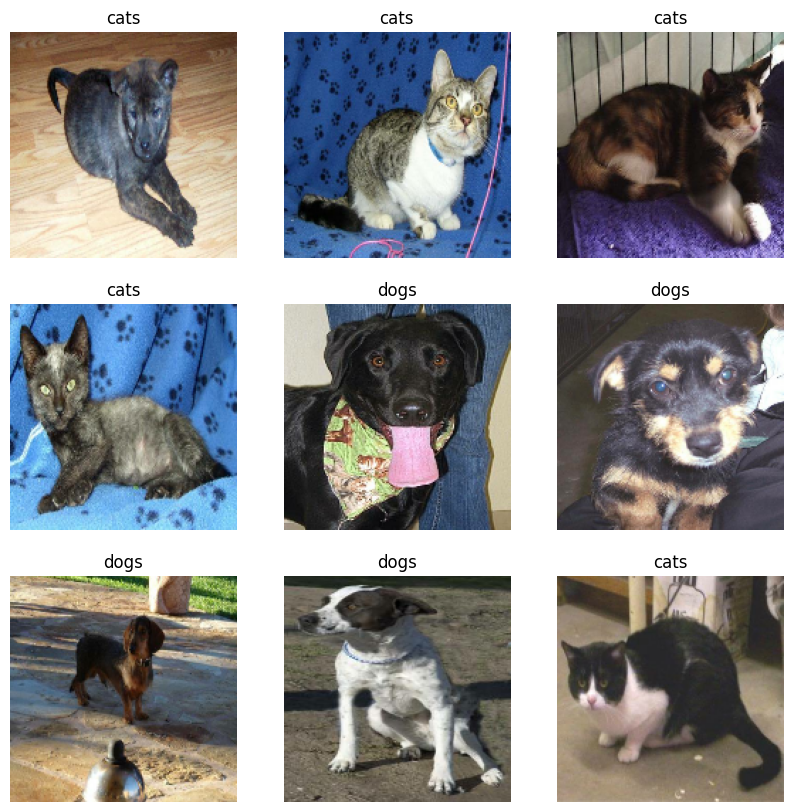

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [ ]:
# Save the model
model_name = "cat-dog-tuned"
model.save(model_name)